In [1]:
import findspark
findspark.init()
from pyspark import SparkConf,SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import Row,SQLContext
import sys
import requests
import nltk
from nltk.tokenize import word_tokenize 

from pandas.api.types import CategoricalDtype
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
%matplotlib inline

In [2]:
# create spark configuration
conf = SparkConf()
conf.setAppName("TwitterStreamApp")
# create spark instance with the above configuration
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
# creat the Streaming Context from the above spark context with window size 2 seconds
ssc = StreamingContext(sc, 30)
# setting a checkpoint to allow RDD recovery
ssc.checkpoint("checkpoint_TwitterApp")
# read data from port 9009
dataStream = ssc.socketTextStream("localhost",9010)

In [3]:
old_event_words = ['past','last','old','was','were','did','been','done','went','had','yesterday','ago']
new_event_words = ['coming','will','soon','new','now','today','tomorrow','next']

def check_tweet(tweet):
    text = tweet.replace(',',' ').replace('.',' ').replace(':',' ').replace(';',' ').replace('?',' ').replace('!',' ')\
    .replace('"',' ').replace("'",' ')
    tokenized = word_tokenize(text)   # splitting one tweet to words
    tagged = nltk.pos_tag(tokenized)  # identifying part of speech
    n_old_words = 0
    n_new_words = 0
    
    for word in tagged:
        if (word[1] == 'VB') or (word[1] == 'VBZ') or (word[1] == 'VBP') or (word[0] in new_event_words):
            n_new_words += 1     # if word is a verb in present tense or appears in list new_event_words
        elif (word[1] == 'VBD') or (word[1] == 'VBN') or (word[0] in old_event_words):
            n_old_words += 1     # if word is a verb in past tense or appears in list old_event_words
            
    # my way to determine whether the tweet concerns past or current event
    if n_old_words > n_new_words:
        return(('Old event',1))
    elif n_old_words + 1 < n_new_words:
        return(('New event',1))
    else:
        return(('Hard to determine',1))
    
    
    
def get_sql_context_instance(spark_context):
    if ('sqlContextSingletonInstance' not in globals()):
        globals()['sqlContextSingletonInstance'] = SQLContext(spark_context)
    return globals()['sqlContextSingletonInstance']



def process(time, rdd):
    print("========= %s =========" % str(time))
    try:
        # Get the singleton instance of sqlContext
        sql_context = get_sql_context_instance(rdd.context)

        # Convert RDD[String] to RDD[Row] to DataFrame
        rowRdd = rdd.map(lambda w: Row(new_old=w[0], count=w[1]))
        df = sql_context.createDataFrame(rowRdd)

        # Creates a temporary view using the DataFrame
        df.createOrReplaceTempView("tweets")

        # Do word count on table using SQL and print it
        df_show = sql_context.sql("select new_old, count from tweets")
        df_show.show()
        
        df_plot = df_show.toPandas()
        df_plot['new_old'] = df_plot['new_old'].astype(CategoricalDtype(['New event','Hard to determine','Old event']))
        #display.clear_output(wait=True)  
        plt.figure( figsize = ( 10, 5 ) )
        ax = sns.barplot( x="count", y="new_old", data=df_plot)
        ax.set(xlabel='Number of tweets', ylabel='Concerns current or past event?', title="Tweets with phrase 'govern'")
        plt.show()
        
    except:
        pass

========= 2020-05-09 19:59:00 =========
========= 2020-05-09 19:59:30 =========
========= 2020-05-09 20:00:00 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|Hard to determine|    1|
+-----------------+-----+



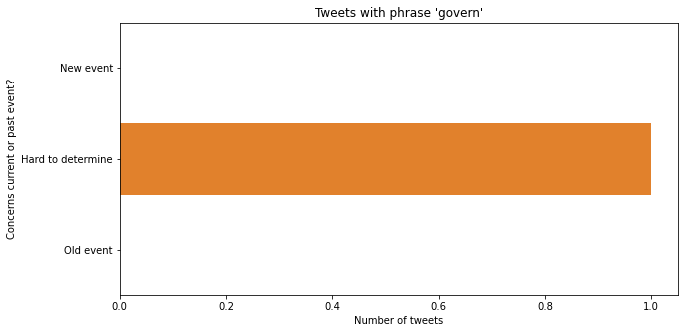

========= 2020-05-09 20:00:30 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    1|
|Hard to determine|    1|
+-----------------+-----+



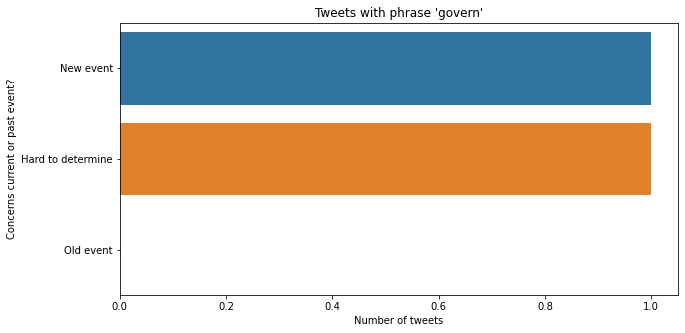

========= 2020-05-09 20:01:00 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    2|
|Hard to determine|    1|
+-----------------+-----+



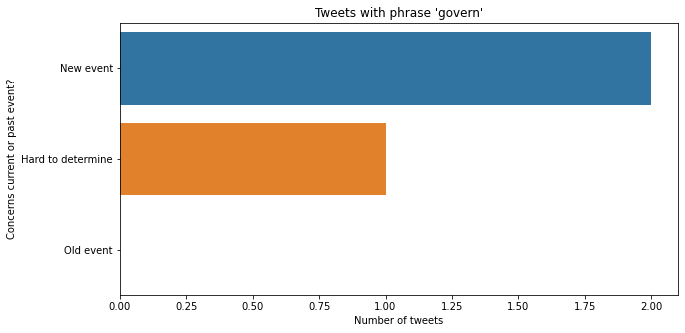

========= 2020-05-09 20:01:30 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    2|
|Hard to determine|    1|
+-----------------+-----+



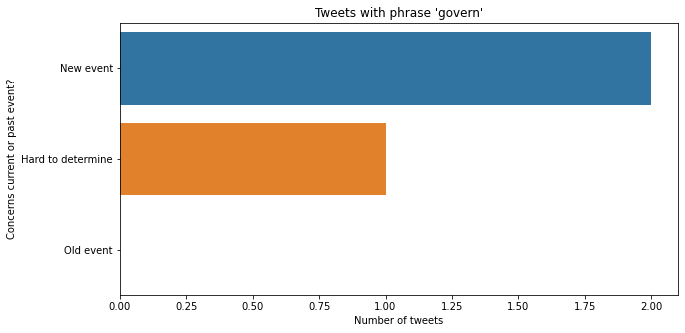

========= 2020-05-09 20:02:00 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    2|
|Hard to determine|    1|
+-----------------+-----+



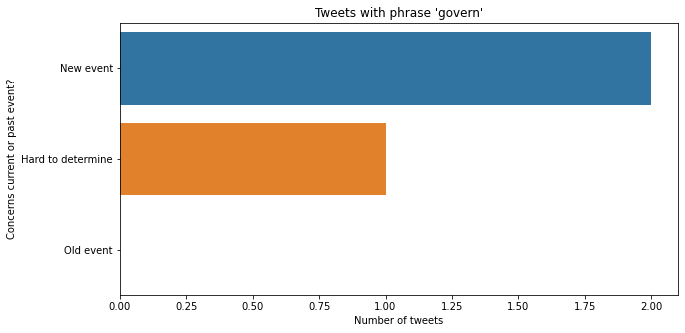

========= 2020-05-09 20:02:30 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    3|
|Hard to determine|    1|
+-----------------+-----+



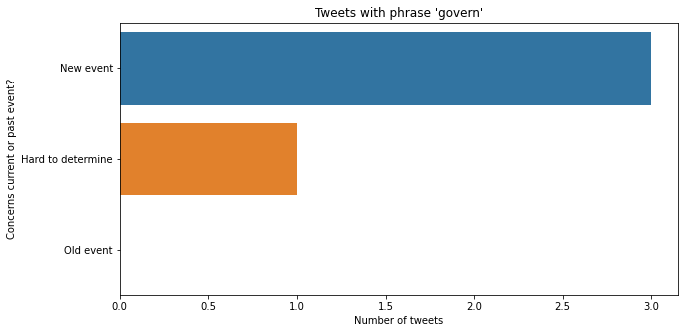

========= 2020-05-09 20:03:00 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    3|
|Hard to determine|    1|
+-----------------+-----+



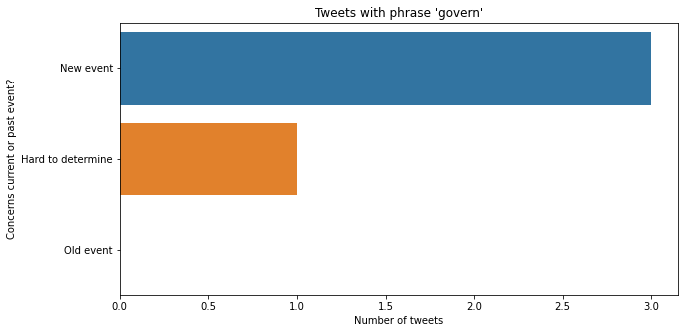

========= 2020-05-09 20:03:30 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    4|
|        Old event|    1|
|Hard to determine|    1|
+-----------------+-----+



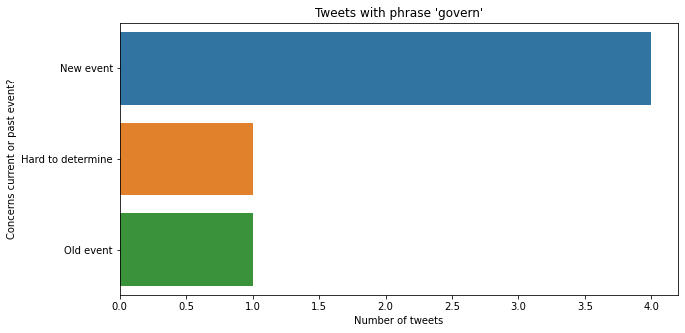

========= 2020-05-09 20:04:00 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    4|
|        Old event|    1|
|Hard to determine|    2|
+-----------------+-----+



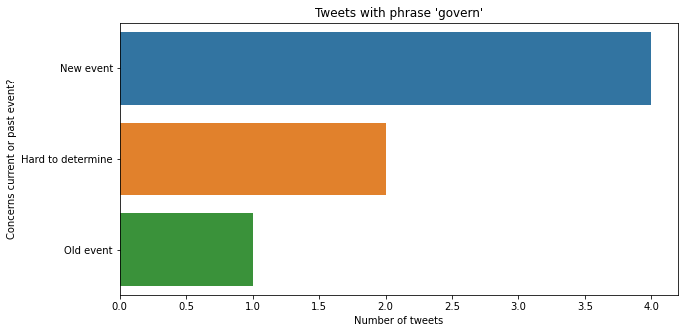

========= 2020-05-09 20:04:30 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    5|
|        Old event|    1|
|Hard to determine|    2|
+-----------------+-----+



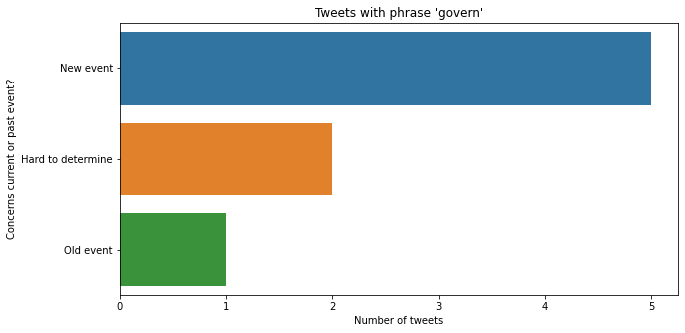

========= 2020-05-09 20:05:00 =========
+-----------------+-----+
|          new_old|count|
+-----------------+-----+
|        New event|    5|
|        Old event|    1|
|Hard to determine|    2|
+-----------------+-----+



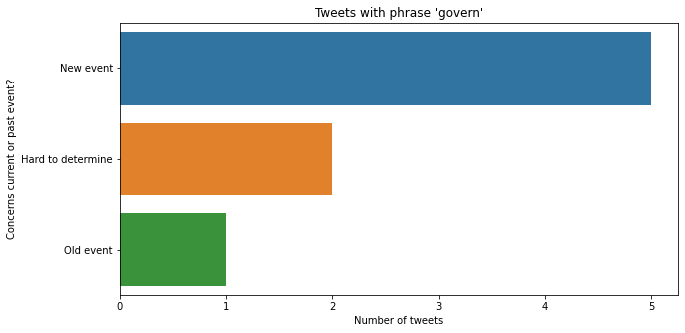

In [ ]:
# split each tweet into words
old_new_event = dataStream.map(check_tweet)  # for each tweet I check whether it concerns new or old event
#old_new_event.pprint(25)
old_new_grouped = old_new_event.updateStateByKey(lambda x,y: sum(x) + (y or 0))  # I count those categories from the beginning of streaming process
old_new_grouped.foreachRDD( process ) 

# start the streaming computation
ssc.start()

# wait for the streaming to finish
ssc.awaitTermination()


Remark: I commented the line display.clear_output(wait=True) to see the whole history displayed. But this is the way to create the 'live' plot (when we don't print the time and table).